In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from matplotlib import rc
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F

# Create Encoder

In [24]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim = 64): # embedding_dim = latent dimension.
    super(Encoder, self).__init__()

    self.seq_len = seq_len
    self.n_features = n_features
    self.embedding_dim = embedding_dim
    self.hidden_dim = 2 * embedding_dim

    # Our encoder consists two layers of LSTM


    self.rnn1 = nn.LSTM(                 # First LSTM layer
      input_size = n_features,
      hidden_size  = self.hidden_dim,
      num_layers = 1,
      batch_first = True
    )

    self.rnn2 = nn.LSTM(                 # Second LSTM layer. For second LSTM layer input is the output of first hidden_dim,
                                         # output shape of first LSTM ( seqlen x batchsize x hiddensize (features in hidden state))
      input_size = self.hidden_dim,
      hidden_size = embedding_dim,
      num_layers = 1,
      batch_first = True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))  # reshaping data to input to encoder. using batch size = 1
                                                       # data dimension = (batchsize, seq_len, inputsize)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)   # hidden ( numlayers x Batchsize x hiddensize ). For LSTM 2,hiddensize = embedd_dim

    return hidden_n.reshape((self.n_features, self.embedding_dim)) # (1 x 64)

# Create the instance of encoder

In [25]:
enc = Encoder(140, 1, 64)

# Create the data to test the encoder

In [26]:
data = torch.rand(1, 140, 1)

# Get the output from the encoder

In [27]:
output_encoder = enc(data)
output_encoder.shape

torch.Size([1, 64])

# Create the Decoder

In [28]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len = seq_len
    self.input_dim = input_dim
    self.hidden_dim = 2 * input_dim
    self.n_features = n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features) # (hidden, feature)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)                    # convert encoder output to (seqlen x input_dim)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim)) # (featuresize x seqlen x input_dim = 64)

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)  # The output shape for second LSTM is (seqlen x batchszie x hiddensize)
    x = x.reshape((self.seq_len, self.hidden_dim)) # we reshape the output of second LSTM (seqlen x hidden)

    return self.output_layer(x)   # Since now x = (seqlen, hidden) and output linear layer = (hidden, features)
                                  # Therefore, final layer is (seqlen x features)

# Creating the instance of decoder

In [29]:
dec = Decoder(140, 64, 1)

# Get the output from the decoder

In [30]:
output_decoder = dec(output_encoder)
output_decoder.shape

torch.Size([140, 1])

# Combine Encoder and Decoder to create LSTM Autoencder

In [31]:
class LSTMAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(LSTMAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim)
    self.decoder = Decoder(seq_len, embedding_dim, n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

# Create the instance of LSTM Autoencoder

In [32]:
model = LSTMAutoencoder(140, 1, 128)

# Get the output from Untrained LSTM Autoencoder

In [33]:
y_model = model(data)

In [34]:
y_model.shape

torch.Size([140, 1])

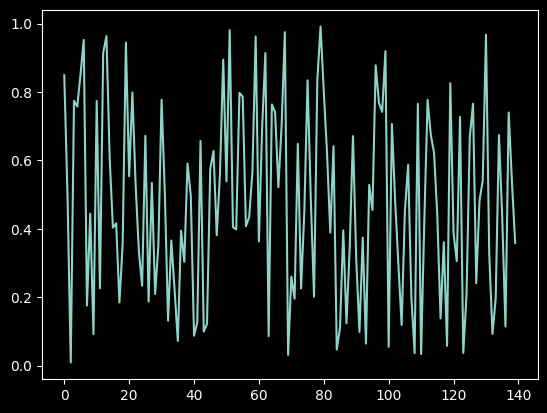

In [35]:
plt.plot(data.numpy().squeeze())

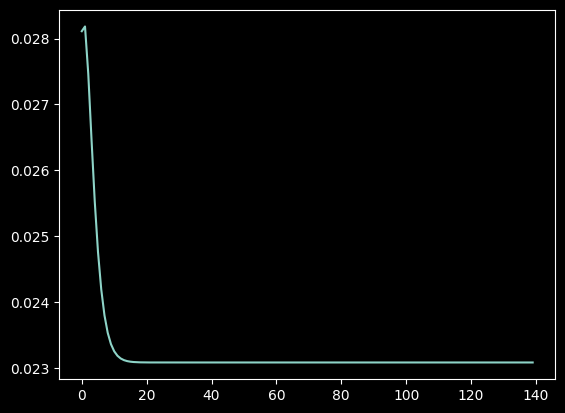

In [36]:
plt.plot(y_model.detach().numpy().squeeze()) # Since model is not trained.